In [1]:
import geopandas as gpd
import rasterio
import rasterio.warp
from rasterio.transform import from_bounds
from rasterio.transform import array_bounds
from rasterio.plot import show
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from shapely.geometry import Point, Polygon
import os
import zipfile
from pykml import parser
from PIL import Image
import geopandas as gpd
from pyproj import Transformer
from skimage.filters import sobel
from rasterio.features import rasterize
from scipy.stats import ttest_ind
from affine import Affine



# !pip install geemap
# pip install --upgrade geemap folium
import ee 
import geemap

In [2]:
# Load shapefiles
young_forest_stands = gpd.read_file('/Users/nicolecleland/Desktop/GSDS/96StormRecovery/standage/repro_standage/erth441youngreproj.shp')
old_forest_stands = gpd.read_file('/Users/nicolecleland/Desktop/GSDS/96StormRecovery/standage/repro_standage/erth441oldreproj.shp')
initiation_sites = gpd.read_file('/Users/nicolecleland/Desktop/GSDS/96StormRecovery/initiation/initiationstorm/erth441storminitiation.shp')
deposits = gpd.read_file('/Users/nicolecleland/Desktop/GSDS/96StormRecovery/deposit/stormdeposits/erth441deposits.shp')
runout_lines = gpd.read_file('/Users/nicolecleland/Desktop/GSDS/96StormRecovery/runout/erth441runouts.shp')

# Render tif of degree of saturation
with rasterio.open('/Users/nicolecleland/Desktop/GSDS/96StormRecovery/aoverb/ERTH441_P2_AoverB.tif') as src:
    saturation = src.read(1)

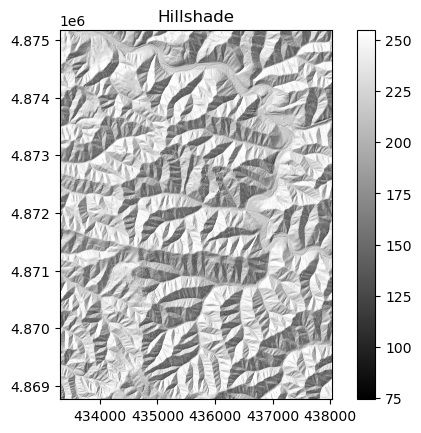

CRS.from_epsg(6339)

In [3]:
# Load DEM
dem_path = '/Users/nicolecleland/Desktop/GSDS/96StormRecovery/dem/knowles_1.tif'
with rasterio.open(dem_path) as dem:
    dem_data = dem.read(1)
    dem_meta = dem.meta
    dem_crs = dem.crs
    dem_transform = dem.transform
    dem_bounds = dem.bounds

# Generate hillshade
def hillshade(array, azimuth=315, angle_altitude=45):
    x, y = np.gradient(array)
    slope = np.pi / 2. - np.arctan(np.sqrt(x * x + y * y))
    aspect = np.arctan2(-x, y)
    azimuth_rad = azimuth * np.pi / 180.
    altitude_rad = angle_altitude * np.pi / 180.
    shaded = np.sin(altitude_rad) * np.sin(slope) + np.cos(altitude_rad) * np.cos(slope) * np.cos(azimuth_rad - aspect)
    return 255 * (shaded + 1) / 2

hillshade_array = hillshade(dem_data)

# Plot hillshade
plt.imshow(hillshade_array, cmap='gray', extent=(dem.bounds.left, dem.bounds.right, dem.bounds.bottom, dem.bounds.top))
plt.title('Hillshade')
plt.colorbar()
plt.show()

dem.crs

In [4]:
# Define tuples to store KMZ and corresponding JPG file paths
file_pairs = [
    ('/Users/nicolecleland/Desktop/GSDS/96StormRecovery/ERTH441aerialimagery/7-16-6.kmz', '/Users/nicolecleland/Desktop/GSDS/96StormRecovery/ERTH441aerialimagery/7-16-6.jpg'),
    ('/Users/nicolecleland/Desktop/GSDS/96StormRecovery/ERTH441aerialimagery/7-16-7.kmz', '/Users/nicolecleland/Desktop/GSDS/96StormRecovery/ERTH441aerialimagery/7-16-7.jpg'),
    ('/Users/nicolecleland/Desktop/GSDS/96StormRecovery/ERTH441aerialimagery/7-16-8.kmz', '/Users/nicolecleland/Desktop/GSDS/96StormRecovery/ERTH441aerialimagery/7-16-8.jpg'),
    ('/Users/nicolecleland/Desktop/GSDS/96StormRecovery/ERTH441aerialimagery/7-16-9.kmz', '/Users/nicolecleland/Desktop/GSDS/96StormRecovery/ERTH441aerialimagery/7-16-9.jpg')
]


In [5]:
# Extract KML from KMZ
def extract_kml_from_kmz(kmz_path):
    with zipfile.ZipFile(kmz_path, 'r') as kmz:
        kml_filename = [name for name in kmz.namelist() if name.endswith('.kml')][0]
        with kmz.open(kml_filename) as kml_file:
            return kml_file.read()

# Get georeferencing info
def get_georeferencing_info(kml_content):
    root = parser.fromstring(kml_content)
    ns = {'kml': 'http://www.opengis.net/kml/2.2'}
    ground_overlay = root.find('.//kml:GroundOverlay', namespaces=ns)
    if ground_overlay is not None:
        lat_lon_box = ground_overlay.find('.//kml:LatLonBox', namespaces=ns)
        if lat_lon_box is not None:
            north = float(lat_lon_box.find('kml:north', namespaces=ns).text)
            south = float(lat_lon_box.find('kml:south', namespaces=ns).text)
            east = float(lat_lon_box.find('kml:east', namespaces=ns).text)
            west = float(lat_lon_box.find('kml:west', namespaces=ns).text)
            return north, south, east, west
    raise ValueError("Could not find georeferencing information in the KML file")

# Extract georeferencing info from each KMZ file
georeferencing_info = []
for kmz_path, _ in file_pairs:
    kml_content = extract_kml_from_kmz(kmz_path)
    try:
        georeferencing_info.append(get_georeferencing_info(kml_content))
    except ValueError as e:
        print(f"Error processing {kmz_path}: {e}")


In [6]:
reprojected_photos = []

for i, (kmz_path, photo_path) in enumerate(file_pairs):
    north, south, east, west = georeferencing_info[i]
    
    # Open the image
    with Image.open(photo_path) as img:
        img_array = np.array(img)
        
    # Create an affine transformation from the georeferencing info
    transform = from_bounds(west, south, east, north, img_array.shape[1], img_array.shape[0])
    
    # Reproject the image
    dst_transform, width, height = rasterio.warp.calculate_default_transform(
        'EPSG:4326', dem_crs, img_array.shape[1], img_array.shape[0], left=west, bottom=south, right=east, top=north)
    
    dst_image = np.zeros((3, height, width), dtype=np.uint8)
    
    for band in range(3):
        rasterio.warp.reproject(
            source=img_array[:, :, band],
            destination=dst_image[band],
            src_transform=transform,
            src_crs='EPSG:4326',
            dst_transform=dst_transform,
            dst_crs=dem_crs,
            resampling=rasterio.warp.Resampling.nearest)
    
    reprojected_photos.append((dst_image, dst_transform, dem_crs))


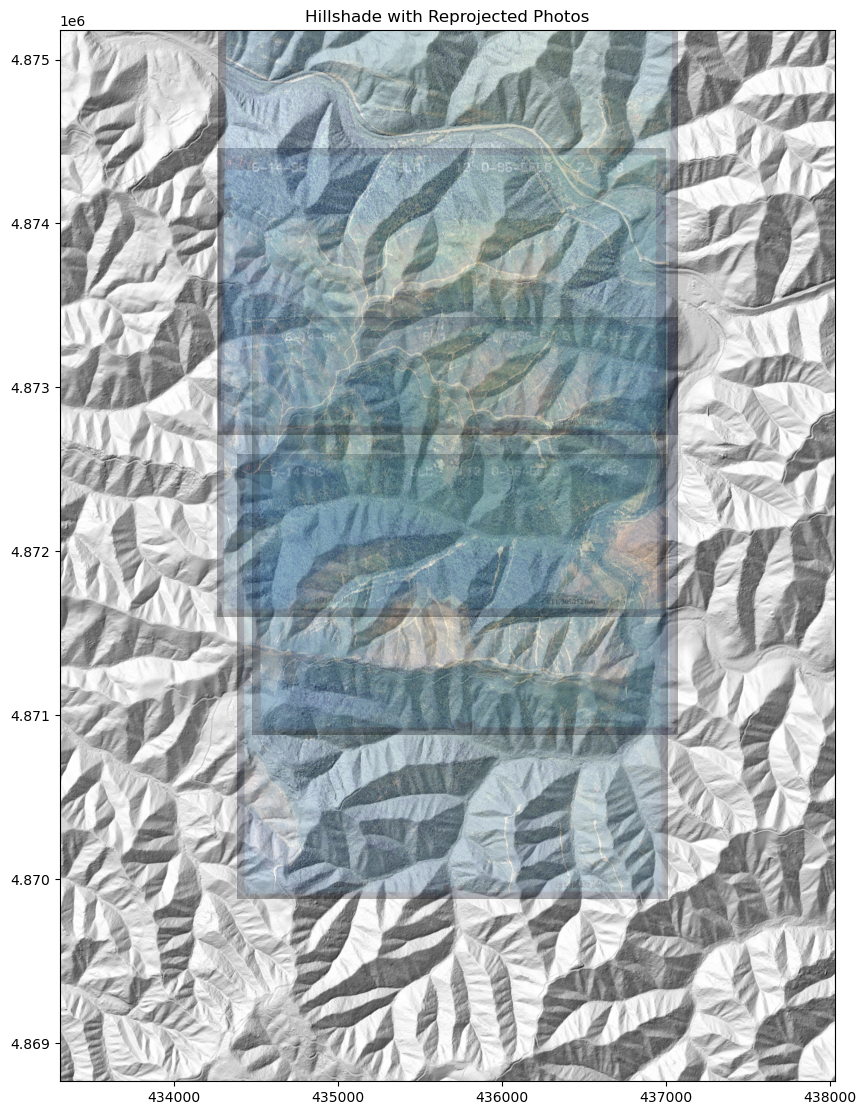

In [7]:
def calculate_extent(transform, width, height):
    # Calculate the extent of the image based on the transformation matrix
    bounds = array_bounds(height, width, transform)
    return (bounds[0], bounds[2], bounds[1], bounds[3])

def plot_reprojected_photo(photo, transform, ax, alpha=0.3):
    img_array = np.moveaxis(photo, 0, -1)  # Move channels to the last dimension
    img_array = np.rot90(img_array, k=-1)  # Rotate the image 90 degrees clockwise
    extent = calculate_extent(transform, img_array.shape[1], img_array.shape[0])
    ax.imshow(img_array, extent=extent, alpha=alpha)

# Plotting the hillshade and reprojected photos
fig, ax = plt.subplots(figsize=(10, 20))  # Increase height, keep width same

# Plot hillshade
ax.imshow(hillshade_array, cmap='gray', extent=(dem_bounds.left, dem_bounds.right, dem_bounds.bottom, dem_bounds.top))

# Set the axis limits to the extent of the hillshade
ax.set_xlim(dem_bounds.left, dem_bounds.right)
ax.set_ylim(dem_bounds.bottom, dem_bounds.top)

# Plot reprojected photos
for dst_image, dst_transform, dst_crs in reprojected_photos:
    plot_reprojected_photo(dst_image, dst_transform, ax, alpha=0.3)  # Set transparency here

plt.title('Hillshade with Reprojected Photos')
plt.show()

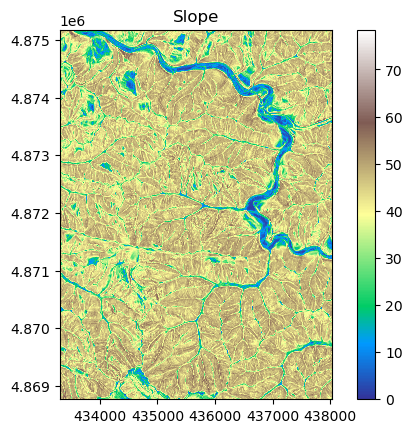

In [8]:
# Compute slope
slope = np.degrees(np.arctan(sobel(dem_data)))

# Save slope layer
slope_path = 'path_to_slope_layer.tif'
slope_meta = dem_meta.copy()
slope_meta.update(dtype=rasterio.float32, count=1)
with rasterio.open(slope_path, 'w', **slope_meta) as dst:
    dst.write(slope.astype(rasterio.float32), 1)

    
# Plot slope
plt.imshow(slope, cmap='terrain', extent=(dem_bounds.left, dem_bounds.right, dem_bounds.bottom, dem_bounds.top))
plt.title('Slope')
plt.colorbar()
plt.show()

In [9]:
# Load Saturation Index
saturation_index_path = '/Users/nicolecleland/Desktop/GSDS/96StormRecovery/aoverb/ERTH441_P2_AoverB.tif'
with rasterio.open(saturation_index_path) as sat_idx:
    sat_data = sat_idx.read(1)
    sat_meta = sat_idx.meta
    sat_crs = sat_idx.crs
    sat_transform = sat_idx.transform
    sat_bounds = sat_idx.bounds

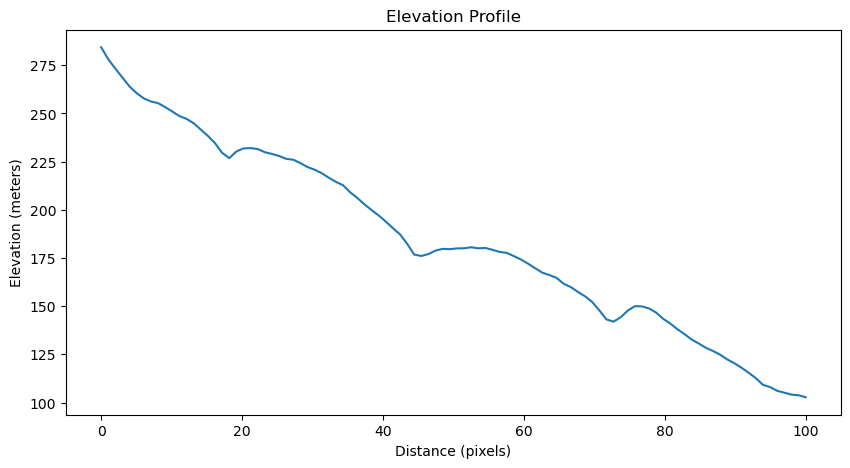

CRS.from_epsg(6339)

In [10]:
# Function to get elevation profile
def get_elevation_profile(dem_data, dem_transform, start_coords, end_coords, num_points=100):
    # Generate linearly spaced points between start and end
    x = np.linspace(start_coords[0], end_coords[0], num_points)
    y = np.linspace(start_coords[1], end_coords[1], num_points)
    
    # Convert to row, column indices
    row, col = rasterio.transform.rowcol(dem_transform, x, y)
    
    # Ensure indices are within the bounds of the DEM array
    row = np.clip(row, 0, dem_data.shape[0] - 1)
    col = np.clip(col, 0, dem_data.shape[1] - 1)
    
    # Extract elevation values
    elevation_profile = dem_data[row, col]
    
    return x, y, elevation_profile

# coordinates for an elevation profile
start_coords = (435882, 4871503) 
end_coords = (436617, 4871600)

# Get elevation profile
x, y, elevation_profile = get_elevation_profile(dem_data, dem_transform, start_coords, end_coords)

# Plot elevation profile
plt.figure(figsize=(10, 5))
plt.plot(np.linspace(0, len(elevation_profile), len(elevation_profile)), elevation_profile)
plt.title('Elevation Profile')
plt.xlabel('Distance (pixels)')
plt.ylabel('Elevation (meters)')
plt.show()

dem.crs

/var/folders/nj/fqqpqqsj59d40h63tltz2smc0000gn/T/ipykernel_60504/2346812637.py:2: RuntimeWarning: divide by zero encountered in log1p
  log_sat_data = np.log1p(sat_data)  # Using log1p for log(1 + x) to handle zero values
/var/folders/nj/fqqpqqsj59d40h63tltz2smc0000gn/T/ipykernel_60504/2346812637.py:2: RuntimeWarning: invalid value encountered in log1p
  log_sat_data = np.log1p(sat_data)  # Using log1p for log(1 + x) to handle zero values


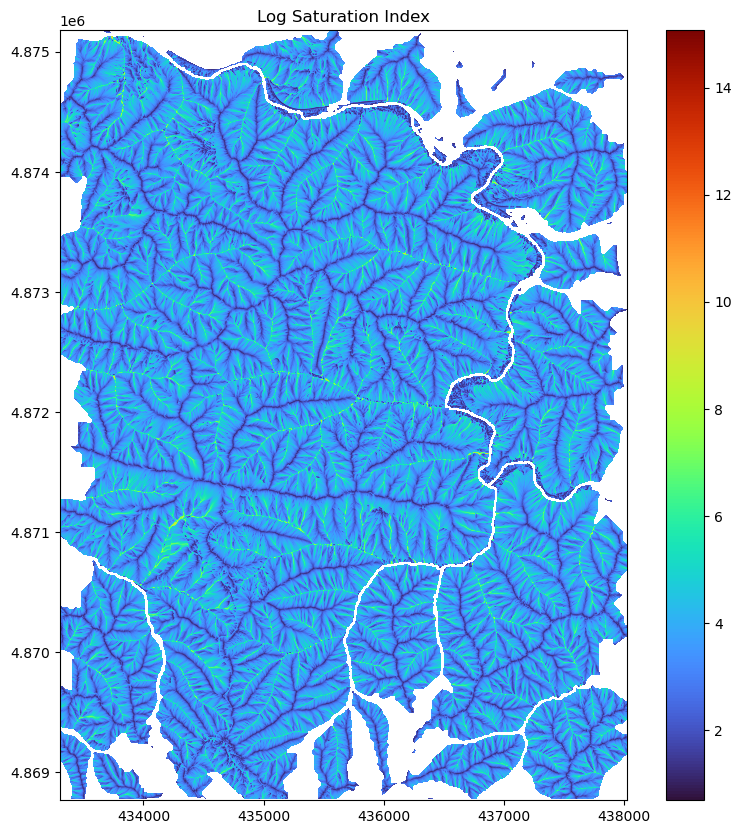

In [11]:
# Calculate the log of the saturation index
log_sat_data = np.log1p(sat_data)  # Using log1p for log(1 + x) to handle zero values

# Save the log saturation index layer
output_dir = '/Users/nicolecleland/Desktop/GSDS/96StormRecovery/aoverb'
os.makedirs(output_dir, exist_ok=True)
log_saturation_index_path = os.path.join(output_dir, 'log_saturation_index.tif')

log_sat_meta = sat_meta.copy()
log_sat_meta.update(dtype=rasterio.float32, count=1)

with rasterio.open(log_saturation_index_path, 'w', **log_sat_meta) as dst:
    dst.write(log_sat_data.astype(rasterio.float32), 1)

# Plot Log Saturation Index
plt.figure(figsize=(10, 10))
plt.imshow(log_sat_data, cmap='turbo', extent=(sat_bounds.left, sat_bounds.right, sat_bounds.bottom, sat_bounds.top))
plt.title('Log Saturation Index')
plt.colorbar()
plt.show()



# NDVI EE

In [12]:
# Define the bounds of the DEM
dem_bounds = {
    'left': 433301.64876,
    'right': 438029.09676,
    'bottom': 4868767.32733,
    'top': 4875180.01453
}

# Define the UTM and geographic coordinate systems using EPSG codes
utm_crs = "EPSG:32610"  # Assuming UTM Zone 10N with WGS84 datum
geo_crs = "EPSG:4326"   # WGS84 geographic coordinate system

# Transform the DEM bounds from UTM to geographic coordinates
transformer = Transformer.from_crs(utm_crs, geo_crs, always_xy=True)

# Transform the UTM coordinates to geographic coordinates
min_lon, min_lat = transformer.transform(dem_bounds['left'], dem_bounds['bottom'])
max_lon, max_lat = transformer.transform(dem_bounds['right'], dem_bounds['top'])

# Define the transformed bounds
geo_bounds = {
    'left': min_lon,
    'right': max_lon,
    'bottom': min_lat,
    'top': max_lat
}

# Calculate the center coordinates of the DEM in geographic coordinates
longitude = (geo_bounds['left'] + geo_bounds['right']) / 2
latitude = (geo_bounds['bottom'] + geo_bounds['top']) / 2


print(f"Geographic Coordinates: Longitude = {longitude}, Latitude = {latitude}")

Geographic Coordinates: Longitude = -123.80239557503185, Latitude = 43.99808660966596


In [13]:
# Ignore unverified HTTPS request warnings
os.environ['PYTHONWARNINGS'] = "ignore:Unverified HTTPS request"

# Authenticate and initialize Earth Engine
ee.Authenticate()
ee.Initialize(project='ee-nicolemcleland-final-gsds')


/opt/anaconda3/lib/python3.11/site-packages/ee/deprecation.py:204: DeprecationWarning: 

Attention required for LANDSAT/LT05/C01/T1_SR! You are using a deprecated asset.
To ensure continued functionality, please update it by July 1, 2024.
Learn more: https://developers.google.com/earth-engine/landsat_c1_to_c2

  warnings.warn(warning, category=DeprecationWarning)


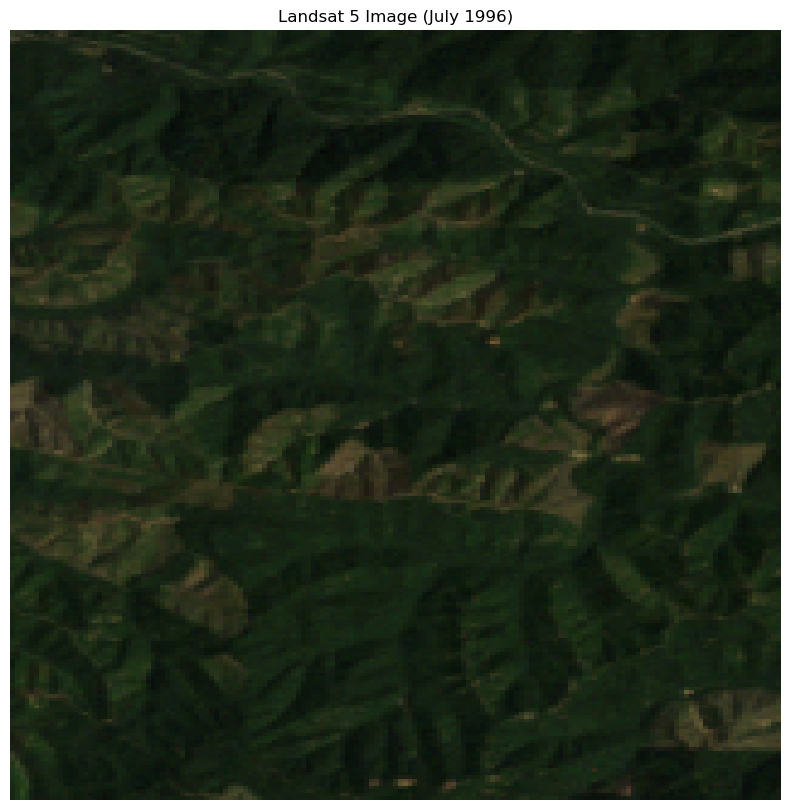

In [14]:
# Create location of interest
# Extract the center coordinates of the DEM
rnapoint = longitude, latitude

# Create Earth Engine point
point = ee.Geometry.Point(rnapoint)

# Set the date range for the month of July
startTime = '1996-07-01'
endTime = '1996-07-31'

# Create Landsat 5 image collection
L5collection = ee.ImageCollection("LANDSAT/LT05/C01/T1_SR") \
                .filterDate(startTime, endTime) \
                .filterBounds(point) \

# Get the first image in the sorted collection
first_image_1996 = L5collection.first()

# Define visualization parameters
vis_params = {
    'bands': ['B3', 'B2', 'B1'],
    'min': 0,
    'max': 3000,
    'gamma': 1.4
}

# Define the region
region = ee.Geometry.Rectangle([geo_bounds['left'], geo_bounds['bottom'], geo_bounds['right'], geo_bounds['top']])

# Get the image as a NumPy array
rgb_image_1996 = geemap.ee_to_numpy(first_image_1996, region=region, bands=['B3', 'B2', 'B1'])

# Normalize the image data for display
rgb_image_1996 = (rgb_image_1996 / 3000.0 * 255).astype(np.uint8)

# Set the extent manually using geo bounds
extent = [geo_bounds['left'], geo_bounds['right'], geo_bounds['bottom'], geo_bounds['top']]


# Plot the image using Matplotlib
plt.figure(figsize=(10, 10))
plt.imshow(rgb_image_1996, extent=extent, origin='upper')
plt.title('Landsat 5 Image (July 1996)')
plt.axis('off')
plt.show()


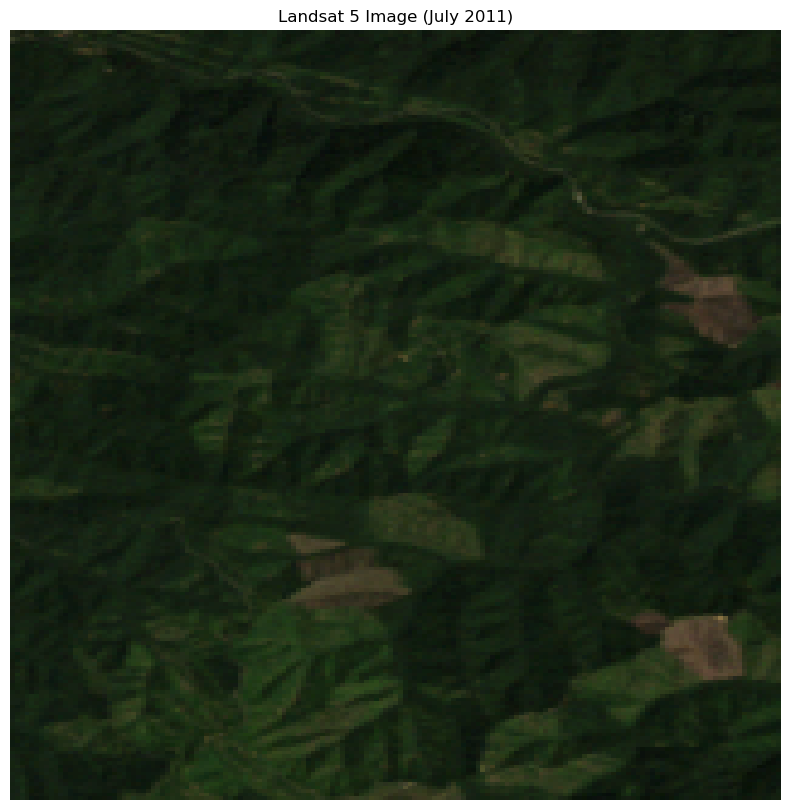

In [15]:
# Create location of interest
# Extract the center coordinates of the DEM
rnapoint = longitude, latitude

# Create Earth Engine point
point = ee.Geometry.Point(rnapoint)

# Set the date range for the month of July 2011
startTime_2011 = '2011-07-01'
endTime_2011 = '2011-07-31'

# Create Landsat 5 image collection
L5collection_2011 = ee.ImageCollection("LANDSAT/LT05/C01/T1_SR") \
                .filterDate(startTime_2011, endTime_2011) \
                .filterBounds(point)

# Get the second image in the collection
L5list = L5collection_2011.toList(2)
second_image_2011 = ee.Image(L5list.get(1))

# Define visualization parameters for Landsat 5
vis_params_2011 = {
    'bands': ['B3', 'B2', 'B1'],  # RGB bands for Landsat 5
    'min': 0,
    'max': 3000,
    'gamma': 1.4
}

# Define the region
region = ee.Geometry.Rectangle([geo_bounds['left'], geo_bounds['bottom'], geo_bounds['right'], geo_bounds['top']])

# Get the image as a NumPy array
rgb_image_2011 = geemap.ee_to_numpy(second_image_2011, region=region, bands=['B3', 'B2', 'B1'])

# Normalize the image data for display
rgb_image_2011 = (rgb_image_2011 / 3000.0 * 255).astype(np.uint8)

# Set the extent manually using geo bounds
extent = [geo_bounds['left'], geo_bounds['right'], geo_bounds['bottom'], geo_bounds['top']]


# Plot the image using Matplotlib
plt.figure(figsize=(10, 10))
plt.imshow(rgb_image_2011, extent=extent, origin='upper')
plt.title('Landsat 5 Image (July 2011)')
plt.axis('off')
plt.show()


In [16]:
# Define the assumed correct CRS
utm_crs = "EPSG:32610"  # Assuming UTM Zone 10N with WGS84 datum

# Override the existing CRS without transforming the geometries
if young_forest_stands.crs is None or young_forest_stands.crs.to_string() != utm_crs:
    young_forest_stands.set_crs(utm_crs, inplace=True, allow_override=True)
if old_forest_stands.crs is None or old_forest_stands.crs.to_string() != utm_crs:
    old_forest_stands.set_crs(utm_crs, inplace=True, allow_override=True)

# Print the bounds of the young forest stand shapefile
young_forest_stand_bounds = young_forest_stands.total_bounds  # Returns [minx, miny, maxx, maxy]
print("Bounds of the young forest stand shapefile (in UTM):")
print(f"Min X: {young_forest_stand_bounds[0]}")
print(f"Min Y: {young_forest_stand_bounds[1]}")
print(f"Max X: {young_forest_stand_bounds[2]}")
print(f"Max Y: {young_forest_stand_bounds[3]}")

# Print the bounds of the old forest stand shapefile
old_forest_stand_bounds = old_forest_stands.total_bounds  # Returns [minx, miny, maxx, maxy]
print("Bounds of the old forest stand shapefile (in UTM):")
print(f"Min X: {old_forest_stand_bounds[0]}")
print(f"Min Y: {old_forest_stand_bounds[1]}")
print(f"Max X: {old_forest_stand_bounds[2]}")
print(f"Max Y: {old_forest_stand_bounds[3]}")

# Transform the bounds to geographic coordinates
transformer = Transformer.from_crs(utm_crs, "EPSG:4326", always_xy=True)

# Transform young forest stand bounds
min_lon_young, min_lat_young = transformer.transform(young_forest_stand_bounds[0], young_forest_stand_bounds[1])
max_lon_young, max_lat_young = transformer.transform(young_forest_stand_bounds[2], young_forest_stand_bounds[3])

# Transform old forest stand bounds
min_lon_old, min_lat_old = transformer.transform(old_forest_stand_bounds[0], old_forest_stand_bounds[1])
max_lon_old, max_lat_old = transformer.transform(old_forest_stand_bounds[2], old_forest_stand_bounds[3])

print("Bounds of the young forest stand shapefile (in WGS84):")
print(f"Min Longitude: {min_lon_young}, Min Latitude: {min_lat_young}")
print(f"Max Longitude: {max_lon_young}, Max Latitude: {max_lat_young}")

print("Bounds of the old forest stand shapefile (in WGS84):")
print(f"Min Longitude: {min_lon_old}, Min Latitude: {min_lat_old}")
print(f"Max Longitude: {max_lon_old}, Max Latitude: {max_lat_old}")


Bounds of the young forest stand shapefile (in UTM):
Min X: 434315.9482619988
Min Y: 4871105.89788349
Max X: 437078.42456488276
Max Y: 4873994.277932081
Bounds of the old forest stand shapefile (in UTM):
Min X: 434301.13605662144
Min Y: 4869846.860426412
Max X: 437108.04897563753
Max Y: 4875349.594724113
Bounds of the young forest stand shapefile (in WGS84):
Min Longitude: -123.8191311881312, Min Latitude: 43.990158639835066
Max Longitude: -123.7850270720027, Max Latitude: 44.01640350329828
Bounds of the old forest stand shapefile (in WGS84):
Min Longitude: -123.81916000083233, Min Latitude: 43.97882268938501
Max Longitude: -123.78481845997908, Max Latitude: 44.02860745515886


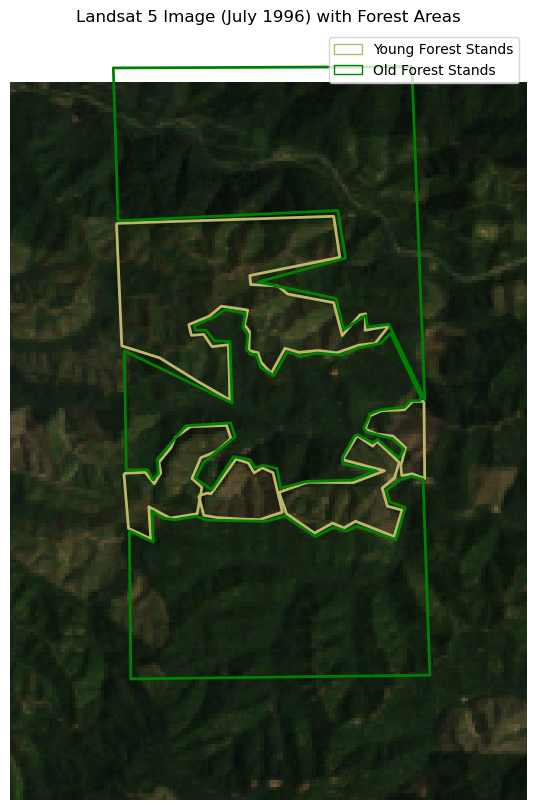

In [17]:
# Check and set the correct CRS if necessary
if young_forest_stands.crs is None or young_forest_stands.crs.to_string() != utm_crs:
    young_forest_stands.set_crs(utm_crs, inplace=True, allow_override=True)
if old_forest_stands.crs is None or old_forest_stands.crs.to_string() != utm_crs:
    old_forest_stands.set_crs(utm_crs, inplace=True, allow_override=True)

# Transform the shapefiles to geographic coordinates
young_forest_stands = young_forest_stands.to_crs(geo_crs)
old_forest_stands = old_forest_stands.to_crs(geo_crs)

# Create custom legend
legend_handles_ishp = [
    Patch(edgecolor='darkkhaki', facecolor='none', label='Young Forest Stands'),
    Patch(edgecolor='green', facecolor='none', label='Old Forest Stands'),
]


# Plot the Landsat image and overlay shapefiles
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(rgb_image_1996, extent=extent, origin='upper')
young_forest_stands.plot(ax=ax, facecolor='none', edgecolor='darkkhaki', linewidth=2, label='Young Forest Stand')
old_forest_stands.plot(ax=ax, facecolor='none', edgecolor='green', linewidth=2, label='Old Forest Stand')
plt.title('Landsat 5 Image (July 1996) with Forest Areas')
plt.legend(handles=legend_handles_ishp, loc='upper right')
plt.axis('off')
plt.show()


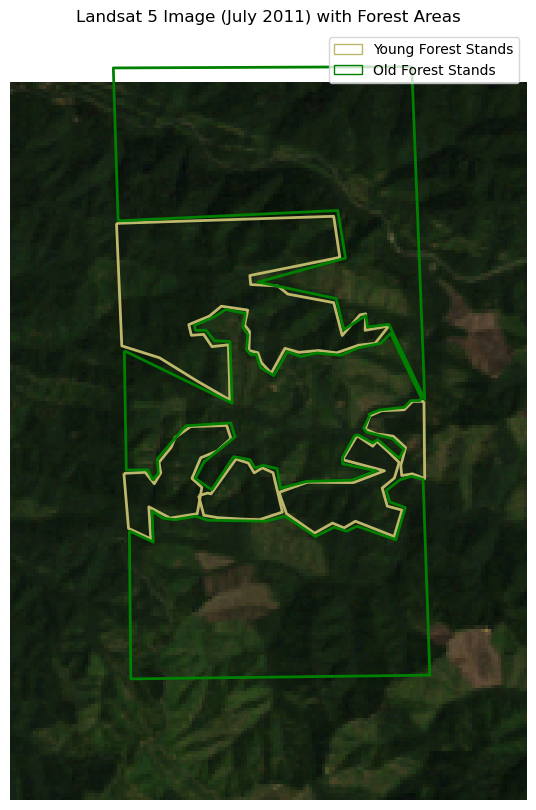

In [18]:
# Plot the Landsat image and overlay shapefiles
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(rgb_image_2011, extent=extent, origin='upper')
young_forest_stands.plot(ax=ax, facecolor='none', edgecolor='darkkhaki', linewidth=2, label='Young Forest Stand')
old_forest_stands.plot(ax=ax, facecolor='none', edgecolor='green', linewidth=2, label='Old Forest Stand')
plt.title('Landsat 5 Image (July 2011) with Forest Areas')
plt.legend(handles=legend_handles_ishp, loc='upper right')
plt.axis('off')
plt.show()


In [19]:
# Calculate NDVI for both images
ndvi_1996 = first_image_1996.normalizedDifference(['B4', 'B3']).rename('NDVI')
ndvi_2011 = second_image_2011.normalizedDifference(['B4', 'B3']).rename('NDVI')

# Define visualization parameters for NDVI
ndvi_vis_params = {
    'min': -1,
    'max': 1,
    'palette': ['blue', 'white', 'green']
}

# Get the NDVI image as a NumPy array
region = ee.Geometry.Rectangle([geo_bounds['left'], geo_bounds['bottom'], geo_bounds['right'], geo_bounds['top']])
ndvi_image_1996 = geemap.ee_to_numpy(ndvi_1996, region=region, bands=['NDVI'])
ndvi_image_2011 = geemap.ee_to_numpy(ndvi_2011, region=region, bands=['NDVI'])

# Calculate the difference in NDVI
ndvi_diff = ndvi_image_2011 - ndvi_image_1996

# Normalize the NDVI difference for display
ndvi_diff_normalized = (ndvi_diff - np.min(ndvi_diff)) / (np.max(ndvi_diff) - np.min(ndvi_diff))


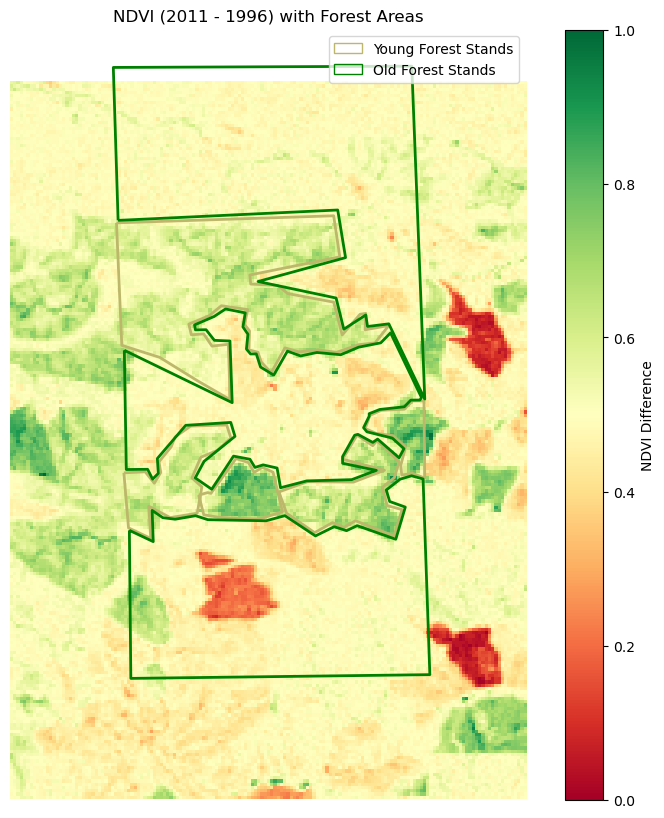

In [20]:
# Plot the NDVI difference and overlay forest shapefiles
fig, ax = plt.subplots(figsize=(10, 10))
cmap = plt.cm.RdYlGn  # Red to green colormap
cax = ax.imshow(ndvi_diff_normalized, extent=extent, cmap=cmap, origin='upper')
young_forest_stands.plot(ax=ax, facecolor='none', edgecolor='darkkhaki', linewidth=2, label='Young Forest')
old_forest_stands.plot(ax=ax, facecolor='none', edgecolor='green', linewidth=2, label='Old Forest')
plt.colorbar(cax, ax=ax, orientation='vertical', label='NDVI Difference')
plt.title('NDVI (2011 - 1996) with Forest Areas')
plt.legend(handles=legend_handles_ishp, loc='upper right')
plt.axis('off')
plt.show()

In [21]:
# ensure shapefiles are in EPSG:6339
target_crs = 'EPSG:6339'
deposits = deposits.to_crs(target_crs)
initiation_sites = initiation_sites.to_crs(target_crs)
young_forest_stands = young_forest_stands.to_crs(target_crs)
old_forest_stands = old_forest_stands.to_crs(target_crs)
runout_lines = runout_lines.to_crs(target_crs)

# Load DEM data
with rasterio.open(dem_path) as dem_dataset:
    dem_data1 = dem_dataset.read(1)
    dem_transform1 = dem_dataset.transform

In [22]:
# Transform the shapefiles to geographic coordinates

print(initiation_sites.crs)
print(deposits.crs)
print(young_forest_stands.crs)
print(old_forest_stands.crs)
print(runout_lines.crs)
dem_dataset.crs

EPSG:6339
EPSG:6339
EPSG:6339
EPSG:6339
EPSG:6339


CRS.from_epsg(6339)

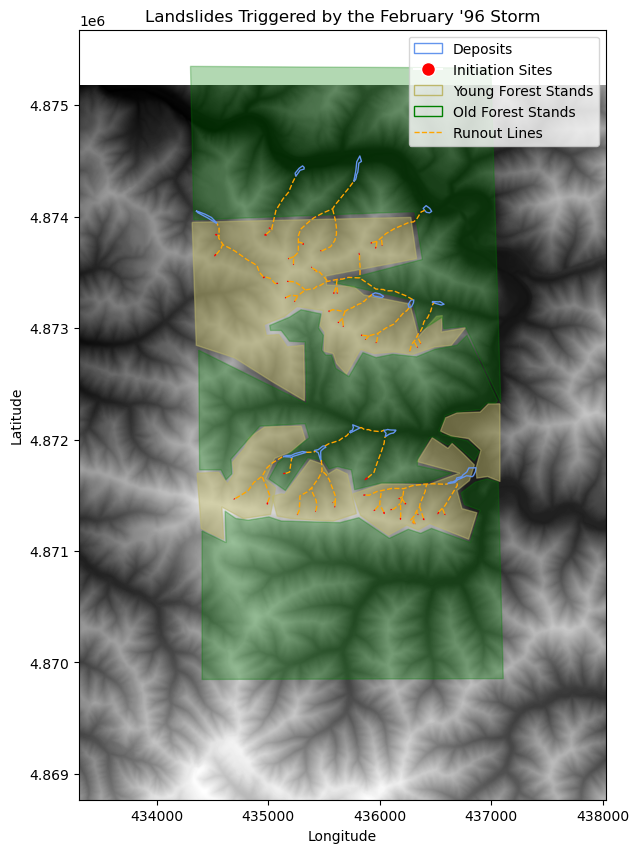

In [23]:

# Create a plot
fig, ax = plt.subplots(figsize=(12, 10))

# Plot DEM
show(dem_data1, transform=dem_transform1, cmap='gray', ax=ax)

# Plot young and old forest stands polygons first
young_forest_stands.plot(ax=ax, edgecolor='darkkhaki', facecolor='darkkhaki', alpha=0.5, label='Young Forest Stands')
old_forest_stands.plot(ax=ax, edgecolor='green', facecolor='green', alpha=0.3, label='Old Forest Stands')

# Plot the other shapefiles on top of the forest stands
deposits.boundary.plot(ax=ax, edgecolor='cornflowerblue', linewidth=1, label='Deposits')
initiation_sites.plot(ax=ax, color='red', linewidth=100, label='Initiation Sites')
runout_lines.plot(ax=ax, color='orange', linewidth=1, linestyle='--', label='Runout Lines')

# Create custom legend
legend_handles = [
    Patch(edgecolor='cornflowerblue', facecolor='none', label='Deposits'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Initiation Sites'),
    Patch(edgecolor='darkkhaki', facecolor='none', label='Young Forest Stands'),
    Patch(edgecolor='green', facecolor='none', label='Old Forest Stands'),
    Line2D([0], [0], color='orange', linewidth=1, linestyle='--', label='Runout Lines')
]

plt.legend(handles=legend_handles, loc='upper right')

# Set plot title and labels
plt.title("Landslides Triggered by the February '96 Storm")
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Show plot
plt.show()

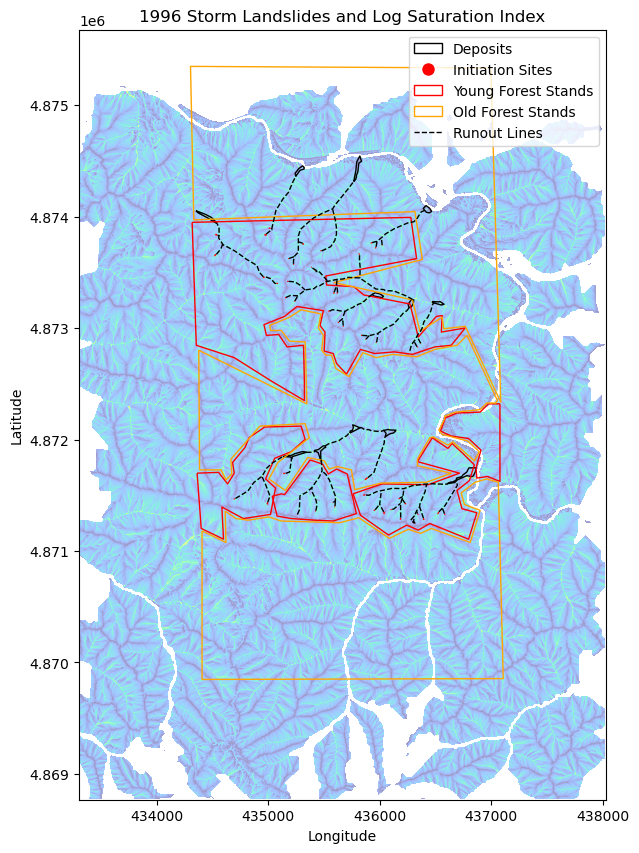

In [24]:
# Create a plot
fig, ax = plt.subplots(figsize=(12, 10))

# Plot Log Saturation Index
plt.imshow(log_sat_data, cmap='turbo', alpha=0.5, extent=(sat_bounds.left, sat_bounds.right, sat_bounds.bottom, sat_bounds.top))

# Plot shapefiles on top of the saturation index
deposits.boundary.plot(ax=ax, edgecolor='black', linewidth=1, label='Deposits')
initiation_sites.plot(ax=ax, color='red', markersize=100, label='Initiation Sites')
young_forest_stands.boundary.plot(ax=ax, edgecolor='red', linewidth=1, label='Young Forest Stands')
old_forest_stands.boundary.plot(ax=ax, edgecolor='orange', linewidth=1, label='Old Forest Stands')
runout_lines.plot(ax=ax, color='black', linewidth=1, linestyle='--', label='Runout Lines')

# Create custom legend
legend_handles = [
    Patch(edgecolor='black', facecolor='none', label='Deposits'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Initiation Sites'),
    Patch(edgecolor='red', facecolor='none', label='Young Forest Stands'),
    Patch(edgecolor='orange', facecolor='none', label='Old Forest Stands'),
    Line2D([0], [0], color='black', linewidth=1, linestyle='--', label='Runout Lines') 
]

plt.legend(handles=legend_handles, loc='upper right')

# Set plot title and labels
plt.title('1996 Storm Landslides and Log Saturation Index')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Show plot
plt.show()


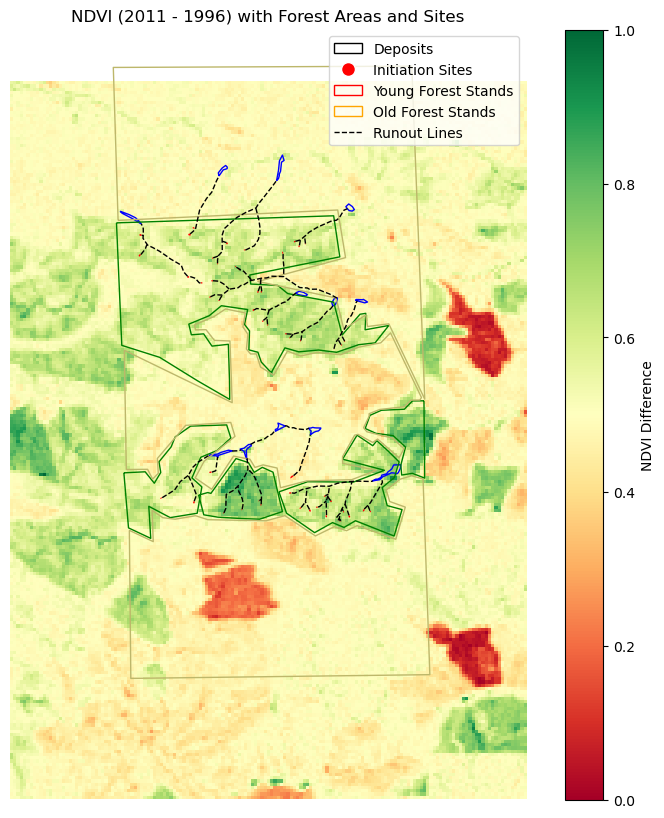

In [28]:
# ensure shapefiles are in EPSG:6339
landsat_crs = geo_crs
deposits = deposits.to_crs(landsat_crs)
initiation_sites = initiation_sites.to_crs(landsat_crs)
young_forest_stands = young_forest_stands.to_crs(landsat_crs)
old_forest_stands = old_forest_stands.to_crs(landsat_crs)
runout_lines = runout_lines.to_crs(landsat_crs)

# Plot the NDVI difference and overlay all shapefiles
fig, ax = plt.subplots(figsize=(10, 10))
cmap = plt.cm.RdYlGn  # Red to green colormap
cax = ax.imshow(ndvi_diff_normalized, extent=extent, cmap=cmap, origin='upper')

# Plotting all shapefiles
# Plot shapefiles on top of DEM
deposits.boundary.plot(ax=ax, edgecolor='blue', linewidth=1, label='Deposits')
initiation_sites.plot(ax=ax, color='red', markersize=100, label='Initiation Sites')
young_forest_stands.boundary.plot(ax=ax, edgecolor='green', linewidth=1, label='Young Forest Stands')
old_forest_stands.boundary.plot(ax=ax, edgecolor='darkkhaki', linewidth=1, label='Old Forest Stands')
runout_lines.plot(ax=ax, color='black', linewidth=1, linestyle='--', label='Runout Lines')

    
# Add colorbar and titles
plt.colorbar(cax, ax=ax, orientation='vertical', label='NDVI Difference')
plt.title('NDVI (2011 - 1996) with Forest Areas and Sites')
plt.legend(handles = legend_handles, loc='upper right')
plt.axis('off')
plt.show()


In [26]:
# Perform spatial join to find initiation sites within each forest stand type
young_joined = gpd.sjoin(initiation_sites, young_forest_stands, how='inner', predicate='within')
old_joined = gpd.sjoin(initiation_sites, old_forest_stands, how='inner', predicate='within')

# Count the number of initiation sites within each forest stand type
young_count = len(young_joined)
old_count = len(old_joined)

print(f'Young Forest Stands with Initiation Sites: {young_count} contributing sites')
print(f'Old Forest Stands with Initiation Sites: {old_count} contributing sites')

Young Forest Stands with Initiation Sites: 51 contributing sites
Old Forest Stands with Initiation Sites: 2 contributing sites


Mean NDVI in Deposits: 0.5413385033607483
Mean NDVI in Initiation Sites: 0.6121134757995605
Mean NDVI in Old Forest Stands: 0.4858788251876831
Mean NDVI in Young Forest Stands: 0.5981187224388123
t-statistic between Deposits and Old Forest Stands: 7.939445894851227, p-value: 6.317250557576015e-13
t-statistic between Initiation Sites and Old Forest Stands: 16.592888603650543, p-value: 1.391546626753853e-32


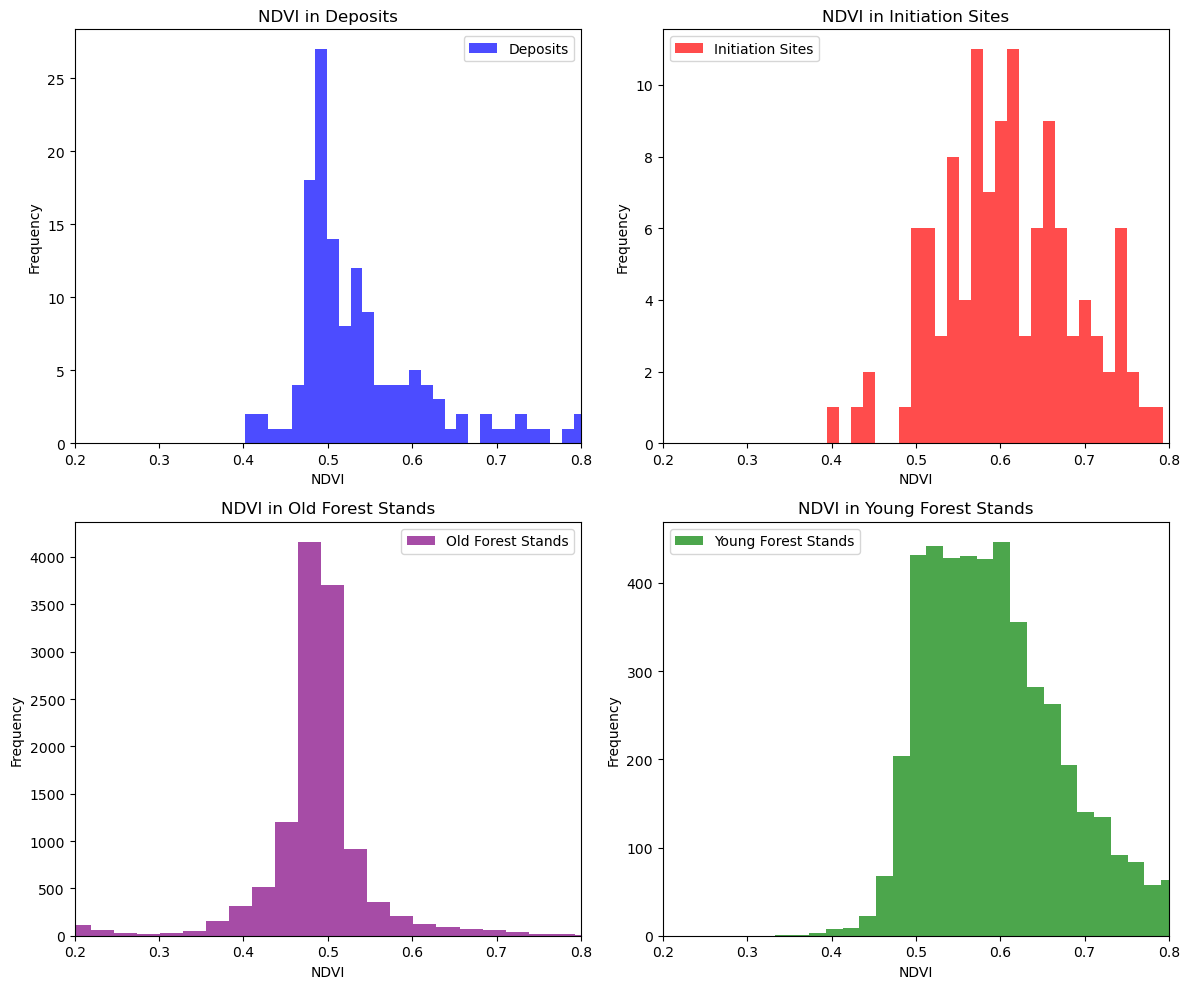

In [27]:
# Ensure all shapefiles are in the same CRS
landsat_crs = geo_crs
deposits = deposits.to_crs(landsat_crs)
initiation_sites = initiation_sites.to_crs(landsat_crs)
young_forest_stands = young_forest_stands.to_crs(landsat_crs)
old_forest_stands = old_forest_stands.to_crs(landsat_crs)
runout_lines = runout_lines.to_crs(landsat_crs)

# Ensure NDVI difference data is 2D
ndvi_diff_normalized = np.squeeze(ndvi_diff_normalized)

# Bounds and resolution (replace with your actual values)
xmin, ymin, xmax, ymax = geo_bounds['left'], geo_bounds['bottom'], geo_bounds['right'], geo_bounds['top']
nrows, ncols = ndvi_diff_normalized.shape
xres = (xmax - xmin) / float(ncols)
yres = (ymax - ymin) / float(nrows)

# Create the affine transform
ndvi_transform = Affine.translation(xmin, ymax) * Affine.scale(xres, -yres)

# Function to extract NDVI values within given polygons
def extract_ndvi_values(polygons, ndvi_data, transform):
    ndvi_values = []
    for poly in polygons.geometry:
        mask = rasterize([(poly, 1)], out_shape=ndvi_data.shape, transform=transform, fill=0, all_touched=True, dtype=np.uint8)
        masked_ndvi = np.ma.masked_array(ndvi_data, mask == 0)
        ndvi_values.extend(masked_ndvi.compressed())
    return ndvi_values

# Extract NDVI values
deposits_ndvi = extract_ndvi_values(deposits, ndvi_diff_normalized, ndvi_transform)
initiation_sites_ndvi = extract_ndvi_values(initiation_sites, ndvi_diff_normalized, ndvi_transform)
young_forest_ndvi = extract_ndvi_values(young_forest_stands, ndvi_diff_normalized, ndvi_transform)
old_forest_ndvi = extract_ndvi_values(old_forest_stands, ndvi_diff_normalized, ndvi_transform)

# Calculate mean NDVI for each area
mean_deposits_ndvi = np.mean(deposits_ndvi)
mean_initiation_sites_ndvi = np.mean(initiation_sites_ndvi)
mean_young_forest_ndvi = np.mean(young_forest_ndvi)
mean_old_forest_ndvi = np.mean(old_forest_ndvi)

# Perform statistical tests
t_stat, p_value = ttest_ind(deposits_ndvi, old_forest_ndvi, equal_var=False)
t_stat_initiation, p_value_initiation = ttest_ind(initiation_sites_ndvi, old_forest_ndvi, equal_var=False)

# Print results
print(f"Mean NDVI in Deposits: {mean_deposits_ndvi}")
print(f"Mean NDVI in Initiation Sites: {mean_initiation_sites_ndvi}")
print(f"Mean NDVI in Old Forest Stands: {mean_old_forest_ndvi}")
print(f"Mean NDVI in Young Forest Stands: {mean_young_forest_ndvi}")

print(f"t-statistic between Deposits and Old Forest Stands: {t_stat}, p-value: {p_value}")
print(f"t-statistic between Initiation Sites and Old Forest Stands: {t_stat_initiation}, p-value: {p_value_initiation}")

# Plot histograms for visual comparison
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

axs[0, 0].hist(deposits_ndvi, bins=30, color='blue', alpha=0.7, label='Deposits')
axs[0, 0].set_title('NDVI in Deposits')
axs[0, 0].set_xlim(0.2, 0.8)

axs[0, 1].hist(initiation_sites_ndvi, bins=30, color='red', alpha=0.7, label='Initiation Sites')
axs[0, 1].set_title('NDVI in Initiation Sites')
axs[0, 1].set_xlim(0.2, 0.8)

axs[1, 0].hist(old_forest_ndvi, bins=30, color='purple', alpha=0.7, label='Old Forest Stands')
axs[1, 0].set_title('NDVI in Old Forest Stands')
axs[1, 0].set_xlim(0.2, 0.8)

axs[1, 1].hist(young_forest_ndvi, bins=30, color='green', alpha=0.7, label='Young Forest Stands')
axs[1, 1].set_title('NDVI in Young Forest Stands')
axs[1, 1].set_xlim(0.2, 0.8)

for ax in axs.flat:
    ax.set_xlabel('NDVI')
    ax.set_ylabel('Frequency')
    ax.legend()

plt.tight_layout()
plt.show()
